<h1> Uncertainty Quantification in Transporting Crude Oil </h1>

One of the main problems in uncertainty quantification is the parsimonious computation of statical moments; treating the model as a black box. In Effective Quadratures there are routines for achieveing prceisely that! In this notebook, we will consider the case where a user would like to estimate key statistical quantities using a numerical integration technique known as sparse grids.

First, we must define our *black box*. Consider the flow of crude oil through a pipe. Our objective is to estimate the power required for transporting the crude oil along a pipe that has a length of $L=1000$ meters and a diameter of $D=1$ meter. The density of crude oil is 870 $kg/m^3$. The two uncertainties are the kinematic viscosity and the flow velocity, given by
- $\mu = $0.0057 kg-s/m
- $v = $5 m/s
both of an uncertainty of $+/-10 \%$. We shall characterize their uncertainties using a Gaussian distribution with a mean of 0.0 and a variance of 0.1. 

In [1]:
import numpy as np
from equadratures import *

Now we must define our black box model. The power is expressed as
$$Power=\Delta P\times Q$$
where
$$\Delta P=2f\left(\frac{L}{D}\right)\left(\rho v^{2}\right), \; \; \; \; Q=\frac{\pi}{4}D^{2}v$$
and assuming the flow is laminar, we have
$$f=\frac{16}{Re} \; \; where \; \; Re=\frac{Dv\rho}{\mu}$$.

Variable $f$ denotes the friction, $\Delta P$ denotes the pressure loss across the pipe, and $Re$ denotes the Reynolds number. These equations are coded in the **blackbox** below.

In [2]:
def blackbox(x):
    mu = x[0]
    velocity = x[1]
    D = 1.0
    L = 1000.0
    density = 870.0
    Q = np.pi * D**2 * velocity * 1.0/4.0
    Reynolds_number = D * velocity * density * 1.0/mu
    f = 16.0 / Reynolds_number
    delta_pressure = 2.0 * f * (L/D) * density * velocity**2
    return delta_pressure * Q

In [3]:
viscosity = Parameter(distribution='Uniform', lower=0.0040, upper=0.0060, order=2)
velocity = Parameter(distribution='Uniform', lower=4.6, upper=5.4, order=2)
#velocity = Parameter(distribution='Beta', shape_parameter_A=1.5, shape_parameter_B=3.2, lower=4.6, upper=5.4, order=5)
mybasis = Basis('Tensor grid')

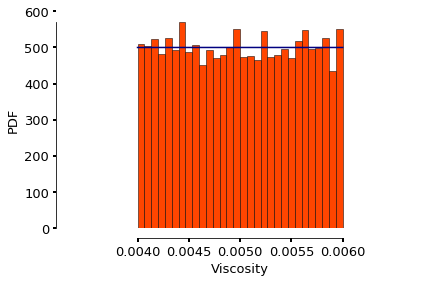

In [4]:
samples = viscosity.getSamples(5000)
x, y  = viscosity.getPDF(5000)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hist(samples, 30, normed=1, facecolor='orangered', edgecolor='black', linewidth=0.5)
plt.plot(x, y, c='navy')
std_dev = np.std(samples)
plt.xlim(np.min(samples) - 1.2* std_dev, np.max(samples) + 1.2*std_dev)
ax.set_axisbelow(True)
adjust_spines(ax, ['left', 'bottom'])
plt.xlabel('Viscosity', fontsize=13)
plt.ylabel('PDF', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

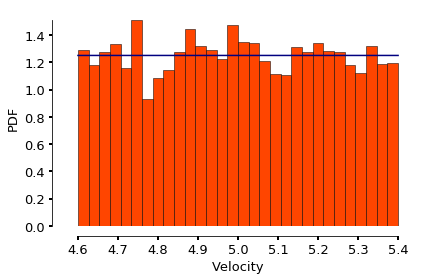

In [5]:
samples = velocity.getSamples(5000)
x, y  = velocity.getPDF(5000)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hist(samples, 30, normed=1, facecolor='orangered', edgecolor='black', linewidth=0.5)
plt.plot(x, y, c='navy')
std_dev = np.std(samples)
#plt.xlim(np.min(samples) - 1.2* std_dev, np.max(samples) + 1.2*std_dev)
ax.set_axisbelow(True)
adjust_spines(ax, ['left', 'bottom'])
plt.xlabel('Velocity', fontsize=13)
plt.ylabel('PDF', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

In [6]:
poly = Polyint([viscosity, velocity], mybasis)
poly.computeCoefficients(blackbox)

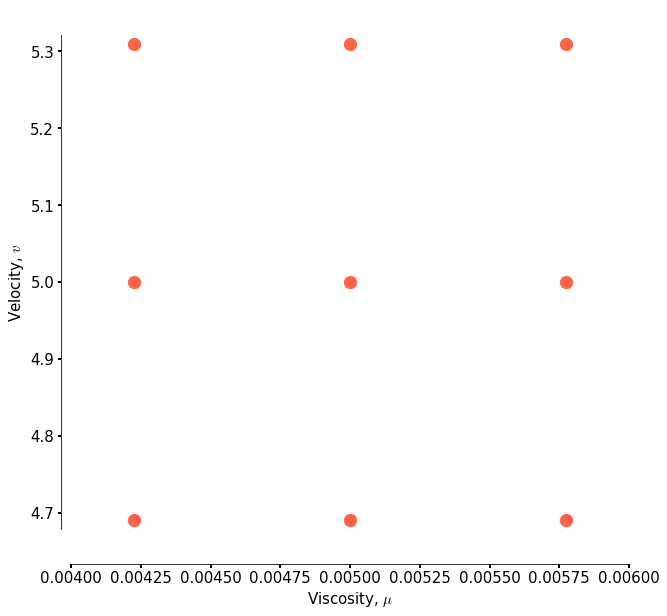

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
plt.scatter(poly.quadraturePoints[:,0], poly.quadraturePoints[:,1] , marker='o', s=150, color='tomato')
adjust_spines(ax, ['left', 'bottom'])
plt.xlabel('Viscosity, $\mu$', fontsize=15)
plt.ylabel('Velocity, $v$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([viscosity.lower, viscosity.upper])
plt.show()

Now lets have a look at the polynomial coefficients, we are looking for an exponential decay in the coefficients---indicating that the polynomial has done a good job interpolating the data.

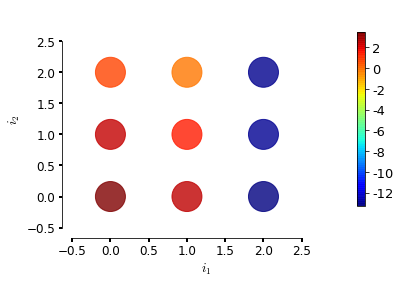

In [8]:
x, y, z, max_order = twoDgrid(poly.coefficients, poly.multi_index)
G = np.log10(np.abs(z))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cax = plt.scatter(x, y, s=900, marker='o', c=G, cmap='jet', alpha=0.8)
plt.xlim(-0.5, max_order)
plt.ylim(-0.5, max_order)
adjust_spines(ax, ['left', 'bottom'])
ax.set_axisbelow(True)
plt.xlabel('$i_1$', fontsize=13)
plt.ylabel('$i_2$', fontsize=13)
cbar = plt.colorbar(extend='neither', spacing='proportional',
                orientation='vertical', shrink=0.8, format="%.0f")
cbar.ax.tick_params(labelsize=13)
plt.show()
del x, y , z

Now let us compute the statistics of power. First lets plot its PDF.

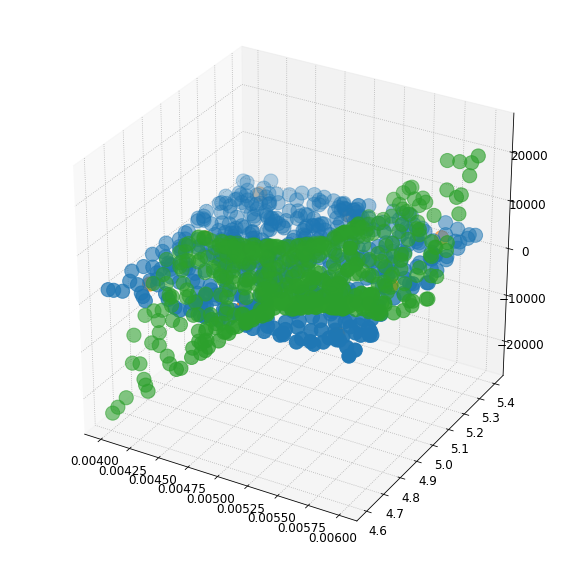

In [9]:
fun = poly.getPolyFitFunction()
x, fx = poly.getFunctionSamples(500)
y = utils.evalfunction(function=blackbox, points=x)
y2 = utils.evalfunction(function=blackbox, points=poly.quadraturePoints)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.grid(True)
ax.scatter(x[:,0], x[:,1],y, s=200)
ax.scatter(poly.quadraturePoints[:,0], poly.quadraturePoints[:,1], y2, s=200)
ax.scatter(x[:,0], x[:,1], fx, s=200)


#ax.view_init(85, 20)
plt.show()
#print x
#print fun(x)
#fig = plt.figure()
#ax = fig.add_subplot(1,1,1)
#plt.hist(fx, 30, normed=1, facecolor='saddlebrown', edgecolor='black', linewidth=0.5)
#std_dev = np.std(samples)
#plt.xlim(np.min(samples) - 1.2* std_dev, np.max(samples) + 1.2*std_dev)
#ax.set_axisbelow(True)
#adjust_spines(ax, ['left', 'bottom'])
#plt.xlabel('Power (Watts)', fontsize=13)
#plt.ylabel('PDF', fontsize=13)
#plt.xticks(fontsize=13)
#plt.yticks(fontsize=13)
#plt.tight_layout()

In [10]:
print blackbox([5.24390555e-03, 5.05073896e+00])
print fun([[5.24390555e-03, 5.05073896e+00]])

3362.05308919
[[98.63354452]]


In [11]:
print poly.basis.elements, poly.coefficients

[[0. 0.]
 [0. 1.]
 [0. 2.]
 [1. 0.]
 [1. 1.]
 [1. 2.]
 [2. 0.]
 [2. 1.]
 [2. 2.]] [[ 3.14829472e+03]
 [ 2.90207898e+02]
 [ 5.99450857e+00]
 [ 3.63533761e+02]
 [ 3.35103216e+01]
 [ 6.92186227e-01]
 [-5.47007136e-14]
 [ 1.02814168e-13]
 [-9.57715123e-14]]
